## Import and clean

In [43]:
import kagglehub
import pandas as pd
import os

# Download and load dataset
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")
file = next(f for f in os.listdir(path) if f.endswith(('.xls', '.xlsx', '.csv')))
file_path = os.path.join(path, file)

# Read Excel or CSV
df = pd.read_excel(file_path) if file.endswith(('.xls', '.xlsx')) else pd.read_csv(file_path, encoding='ISO-8859-1')

# Preview
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [44]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [45]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert dates
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])

# Create new features
df['order_month'] = df['order_date'].dt.to_period('M')
df['profit_margin'] = df['profit'] / df['sales']


## Analysis

### Profit Analysis

In [62]:
# Basic KPIs
total_sales = df['sales'].sum()
total_profit = df['profit'].sum()
avg_profit_margin = df['profit_margin'].mean()
num_orders = df['order_id'].nunique()

print(f"Total Sales: ${total_sales:,.0f}")
print(f"Total Profit: ${total_profit:,.0f}")
print(f"Average Profit Margin: {avg_profit_margin:.2%}")
print(f"Total Orders: {num_orders}")


Total Sales: $2,297,201
Total Profit: $286,397
Average Profit Margin: 12.03%
Total Orders: 5009


#### Profit by Category and Region

- Technology and Office Supplies perform well across all regions.
- Furniture underperforms, especially in Central where it generates losses.
- West leads in profit overall, with Office Supplies as the top contributor.
- Central is the weakest region due to Furniture losses.

**Recommendation**:  
Reduce or reposition Furniture in Central.  
Focus on Office Supplies and Technology in West and East.  
Align category strategy to regional strengths.


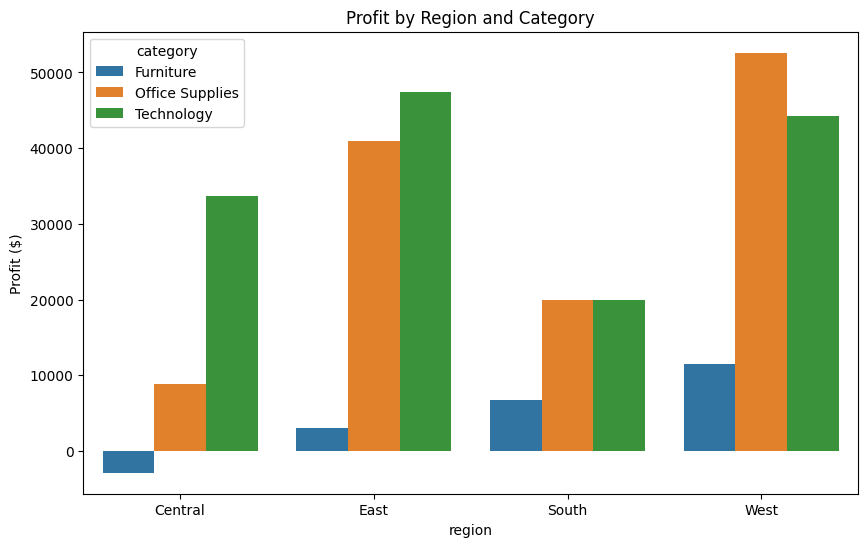

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouped summary
summary = df.groupby(['region', 'category']).agg({
    'sales': 'sum',
    'profit': 'sum'
}).reset_index()

# Visual
plt.figure(figsize=(10,6))
sns.barplot(data=summary, x='region', y='profit', hue='category')
plt.title('Profit by Region and Category')
plt.ylabel('Profit ($)')
plt.show()

#### Profit by Sub-Category

- Copiers, Phones, and Accessories are the top profit drivers.
- Tables and Bookcases are the biggest loss-makers.
- Smaller categories contribute little overall.

**Recommendation**:  
Scale high-performing sub-categories.  
Reassess or phase out underperformers — especially Tables.


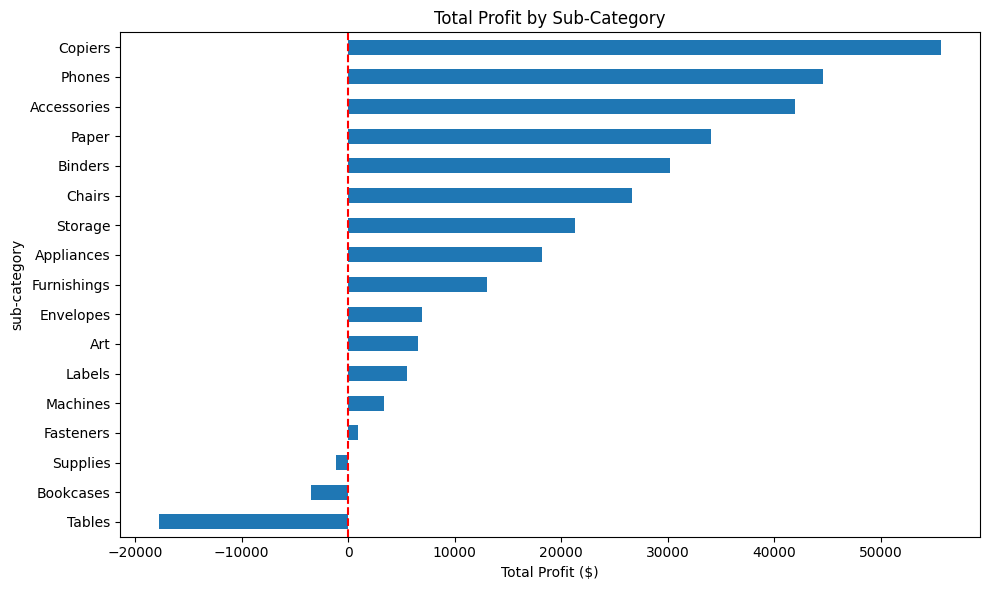

In [67]:
subcat_profit = df.groupby('sub-category')['profit'].sum().sort_values()

plt.figure(figsize=(10,6))
subcat_profit.plot(kind='barh', title='Total Profit by Sub-Category')
plt.xlabel("Total Profit ($)")
plt.axvline(0, linestyle='--', color='red')
plt.tight_layout()
plt.show()



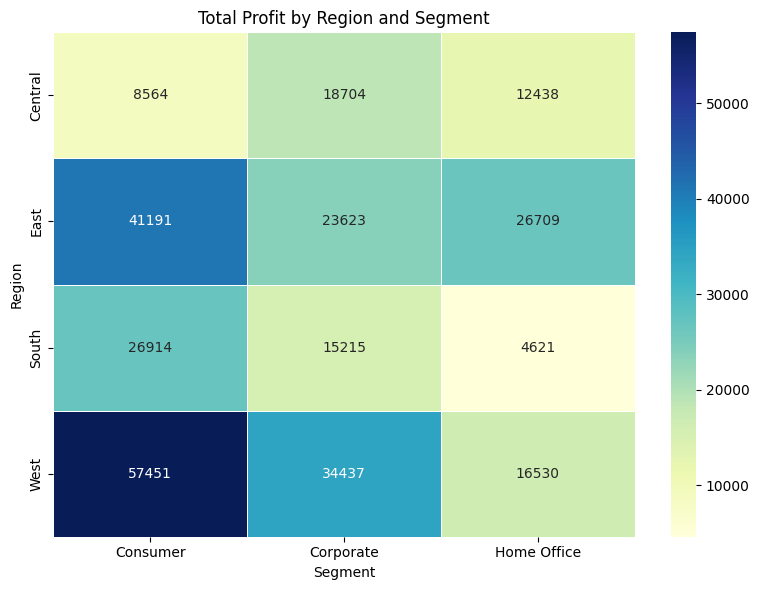

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the pivot table
pivot_matrix = df.pivot_table(
    values='profit',
    index='region',
    columns='segment',
    aggfunc='sum'
).round(2)

# Plot as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_matrix, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Total Profit by Region and Segment")
plt.ylabel("Region")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()



#### Profit by Segment and Region

- West and East have the highest value, driven by the Consumer segment.
- Central and South are weaker, especially South–Home Office.
- Consumer outperforms all other segments across regions (excluding central).

**Recommendation**:  
Focus on Consumer in West and East.  
Reevaluate Home Office in South.


### Discount Analysis

#### Discount Impact on Profit

- Profitability drops sharply when discounts exceed 25%.
- 0–20% discounts include many high-profit sales.
- Above 20%, profits consistently fall below zero.

**Recommendation**:  
Cap standard discounts at 20%.  
Use tighter approval controls for anything higher.


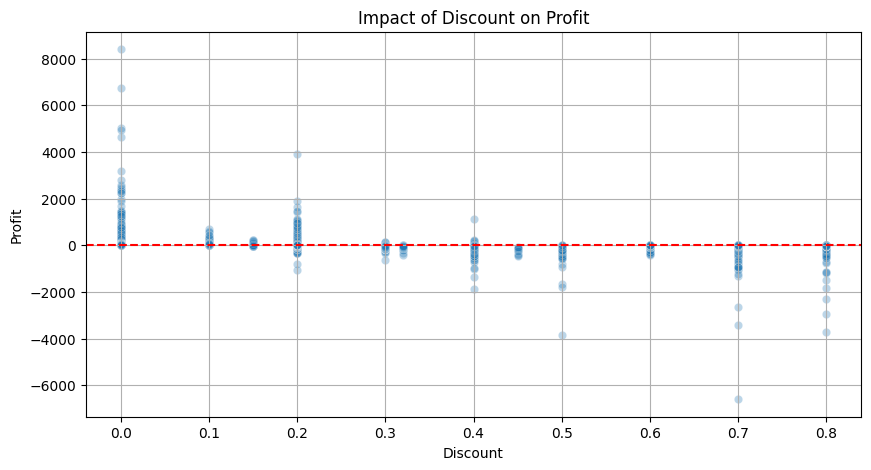

<ipython-input-57-1971fad7f471>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_profit = df.groupby('discount_bin')['profit'].mean()


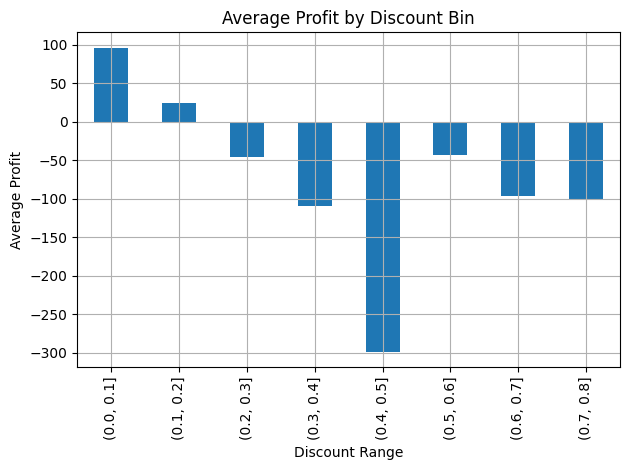

In [57]:
# Discount vs. Profit Scatterplot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='discount', y='profit', alpha=0.3)
plt.title("Impact of Discount on Profit")
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.axhline(0, linestyle='--', color='red')
plt.grid(True)
plt.show()

df['discount_bin'] = pd.cut(df['discount'], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

discount_profit = df.groupby('discount_bin')['profit'].mean()

discount_profit.plot(kind='bar', title='Average Profit by Discount Bin')
plt.ylabel('Average Profit')
plt.xlabel('Discount Range')
plt.grid(True)
plt.tight_layout()
plt.show()


### Customer Analysis

#### Customer LTV by Region

- West and East have the highest customer lifetime sales and profit.
- Central and South lag behind, especially Central in profit.
- Average order value is similar across all regions.

**Recommendation**:  
Focus retention and upsell in West and East.  
Investigate low profitability in Central and South regions.


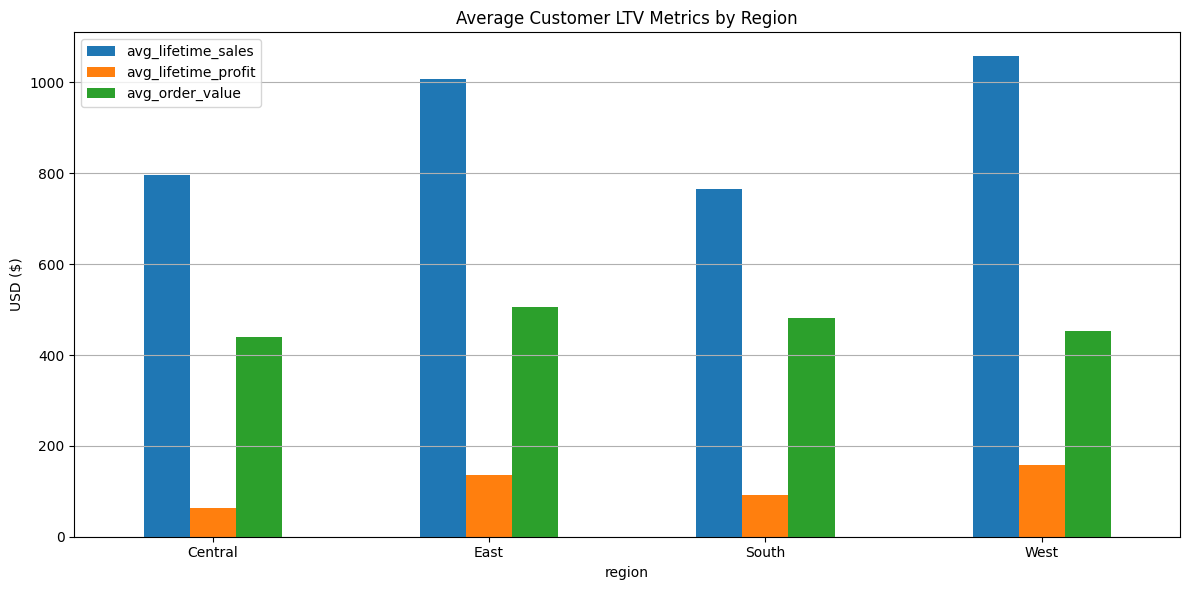

In [42]:
# Recalculate customer-level LTV grouped by region
customer_ltv = df.groupby(['customer_id', 'region']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': pd.Series.nunique
}).reset_index()

customer_ltv['avg_order_value'] = customer_ltv['sales'] / customer_ltv['order_id']
customer_ltv['profit_margin'] = customer_ltv['profit'] / customer_ltv['sales']

# Aggregate to region level
region_ltv = customer_ltv.groupby('region').agg({
    'sales': 'mean',
    'profit': 'mean',
    'avg_order_value': 'mean',
    'profit_margin': 'mean'
}).rename(columns={
    'sales': 'avg_lifetime_sales',
    'profit': 'avg_lifetime_profit',
    'avg_order_value': 'avg_order_value',
    'profit_margin': 'avg_profit_margin'
}).round(2)

# Plot: Average LTV metrics by region
region_ltv[['avg_lifetime_sales', 'avg_lifetime_profit', 'avg_order_value']].plot(
    kind='bar', figsize=(12,6), title='Average Customer LTV Metrics by Region'
)
plt.ylabel('USD ($)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()




#### Profit Share by Sub-Category: Top vs All Customers

- Top customers earn most of their profit from **Binders, Copiers, and Machines**.
- Average customers are more spread out, with higher spend on **Copiers, Phones, Accessories, and Paper**.

**Recommendation**:  
Focus upsell efforts on Binders, Copiers, and Machines for high-value customers.  
Use promotions on popular, lower-margin items to convert average buyers into top-tier ones.


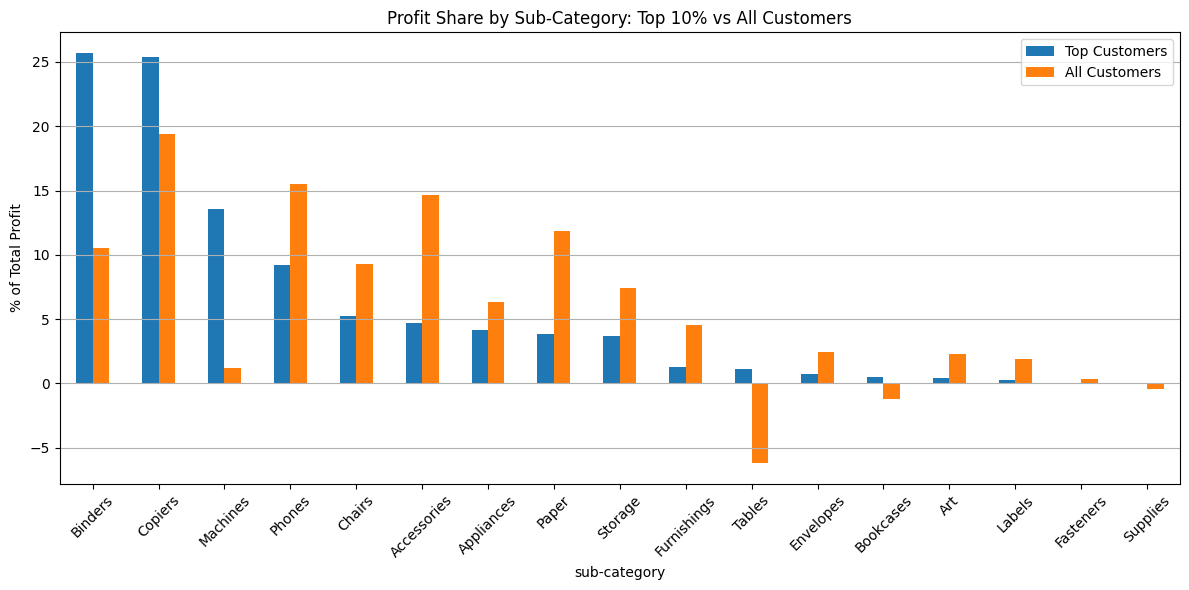

In [66]:
# Step 1: Calculate customer-level LTV
customer_ltv = df.groupby('customer_id').agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': pd.Series.nunique
}).reset_index()

customer_ltv['avg_order_value'] = customer_ltv['sales'] / customer_ltv['order_id']
customer_ltv['profit_margin'] = customer_ltv['profit'] / customer_ltv['sales']

# Step 2: Identify top 10% of customers by profit
threshold = customer_ltv['profit'].quantile(0.90)
top_customers = customer_ltv[customer_ltv['profit'] >= threshold]['customer_id']

# Step 3: Compare profit share by sub-category
df['is_top'] = df['customer_id'].isin(top_customers)

top_profit = df[df['is_top']].groupby('sub-category')['profit'].sum()
all_profit = df.groupby('sub-category')['profit'].sum()

comparison = pd.DataFrame({
    'Top Customers': top_profit,
    'All Customers': all_profit
}).fillna(0)

# Normalize as percentage of total profit
comparison_percent = comparison.divide(comparison.sum(axis=0), axis=1) * 100

# Step 4: Plot
comparison_percent.sort_values('Top Customers', ascending=False).plot(
    kind='bar', figsize=(12, 6), title='Profit Share by Sub-Category: Top 10% vs All Customers'
)
plt.ylabel('% of Total Profit')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Seasonality Analysis

#### Monthly Sales Trend

- Q4 shows clear seasonal peaks, likely tied to holiday demand or promotions.
- Sales are volatile, but the long-term trend is positive.
- 2017 ends at an all-time high above $120,000/month.

**Recommendation**: Prepare for the Q4 surge with focused planning and inventory. Use targeted campaigns to boost slower mid-year periods.


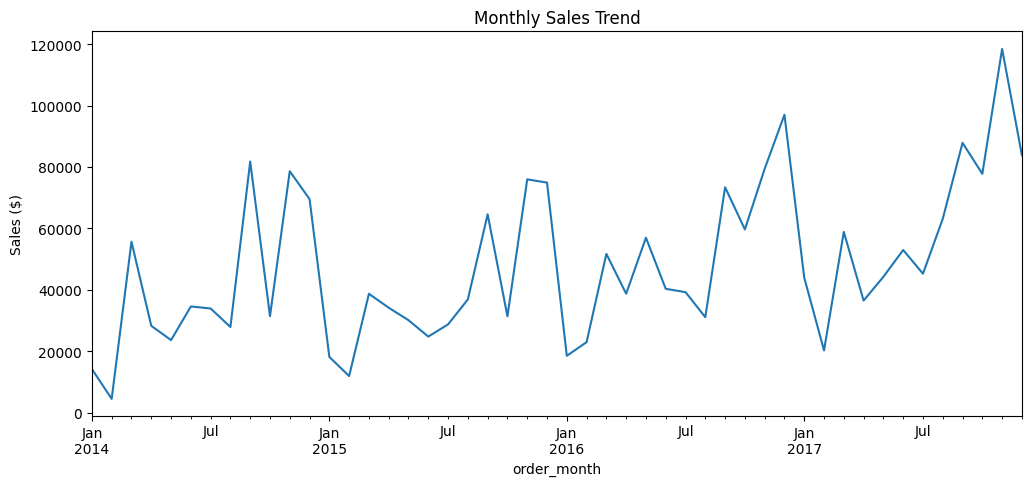

In [61]:
monthly_sales = df.groupby('order_month')['sales'].sum()
monthly_sales.plot(figsize=(12,5), title='Monthly Sales Trend')
plt.ylabel('Sales ($)')
plt.show()


#### Normalized Quarterly Sales by Segment

All segments peak in Q4 and drop in Q1.

- **Consumer**: Strongest seasonality. Always spikes in Q4, lowest in Q1.
- **Corporate**: Follows same pattern as Consumer, but slightly less volatile.
- **Home Office**: Also peaks in Q4, but less consistent mid-year.

**Recommendation**: Focus sales efforts and inventory planning around Q4. Q1 consistently underperforms and may need promotional support.


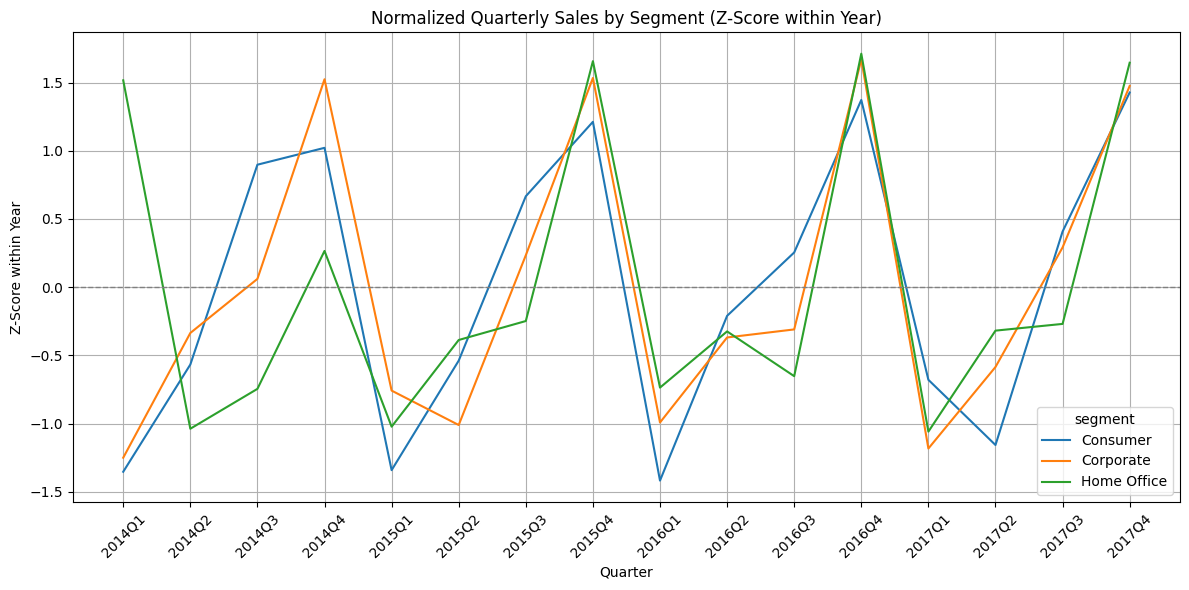

In [81]:
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Extract year and quarter
df['quarter'] = df['order_date'].dt.to_period('Q')

# Group by quarter and segment
quarterly_seg = df.groupby(['quarter', 'segment'])['sales'].sum().unstack()

# Normalize per year (within each set of Q1–Q4)
quarterly_seg['year'] = quarterly_seg.index.year
quarterly_seg_z = quarterly_seg.groupby('year').transform(lambda x: zscore(x, nan_policy='omit'))

# Use string format for quarters
quarter_labels = quarterly_seg.index.astype(str)
quarterly_seg_z.index = quarter_labels

# Plot with forced tick labels
ax = quarterly_seg_z.plot(figsize=(12,6), title='Normalized Quarterly Sales by Segment (Z-Score within Year)')
plt.xticks(ticks=range(len(quarter_labels)), labels=quarter_labels, rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.ylabel('Z-Score within Year')
plt.xlabel('Quarter')
plt.grid(True)
plt.tight_layout()
plt.show()
